In [1]:
import research as rs
import pandas as pd
import yfinance as yf


In [2]:
instr = yf.Ticker("ES=F")
#hist = instr.history(start="2021-08-27", end="2021-09-03",interval='1m')
hist= instr.history(period="2y")
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-10-02,2942.25,2949.00,2874.00,2880.50,2126769,0,0
2019-10-03,2883.75,2912.50,2855.00,2911.75,2037970,0,0
2019-10-04,2911.50,2953.25,2896.75,2951.00,1497975,0,0
2019-10-07,2929.75,2959.50,2928.00,2937.50,1266872,0,0
2019-10-08,2934.50,2950.00,2890.50,2892.50,1865325,0,0


In [3]:
#hist.to_csv('Emini500SP_daily_max.csv')

In [4]:
# import os, glob
# path = "./"
# all_files = glob.glob(os.path.join(path, "*.csv"))
# df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
# df_merged  = pd.concat(df_from_each_file, ignore_index=True)
# df_merged.to_csv( "merged.csv")

In [5]:
hist=hist.reset_index()

In [6]:
def get_volume_bars(data: pd.DataFrame, m: int = None):
    #if volume amounts to more than m, sample a bar
    ts, idx = 0, []
    for i, row in data.iterrows():
        volume=row['Volume']
        ts += volume
        if ts >= m:
            ts = 0; idx.append(i)
            continue
    return data.iloc[idx]

In [7]:
volume_bars=get_volume_bars(hist,1000000)

In [8]:
volume_bars=volume_bars.set_index('Date')

In [9]:
vb_count=volume_bars['Close'].resample('W').count()

In [10]:
df=hist
df['dollar_amt']=0.2*(df['Open']+df['Close'])*df['Volume']/2
def get_dollar_bars(data: pd.DataFrame, m: int = None):
    #if dollars traded amounts to more than m, sample a bar
    # currently we have only 1 min data that doesn't show dollars amount, I use (open+close)*volume/2 to estimate
    # use 20% as margin requirement, for example, if sc2112 trades at 400 CNY, each position should be 1000*400*20%
    ts, idx = 0, []
    for i, row in data.iterrows():
        volume=row['dollar_amt']
        ts += volume
        if ts >= m:
            ts = 0; idx.append(i)
            continue
    return data.iloc[idx]

In [33]:
dollar_bars=get_dollar_bars(df,100000000)
print(len(dollar_bars))

501


In [34]:
dollar_bars=dollar_bars.set_index('Date')

In [35]:
db_count=dollar_bars['Close'].resample('W').count()

<AxesSubplot:xlabel='Date'>

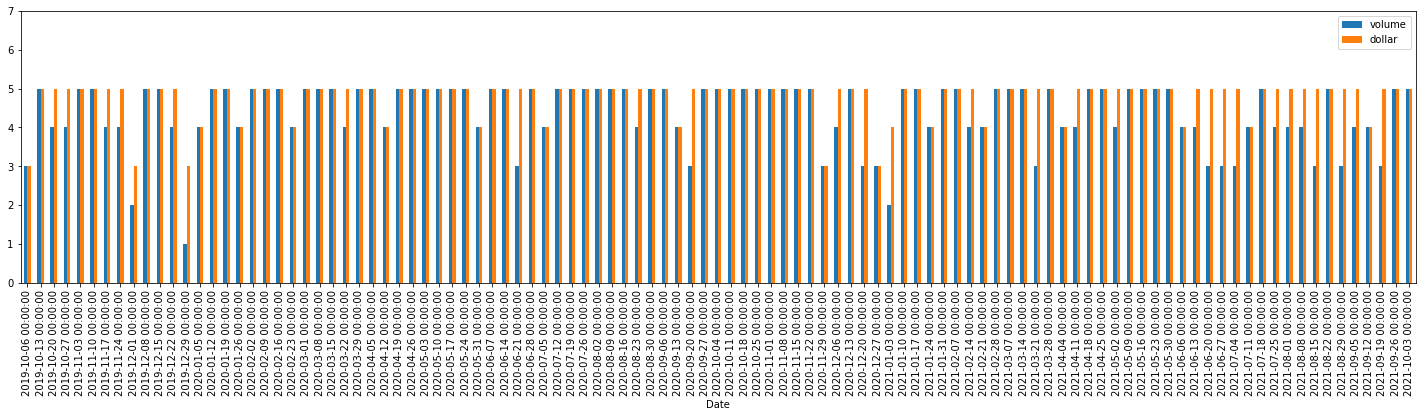

In [38]:
count_df = pd.concat([vb_count, db_count], axis=1)
count_df.columns = ['volume', 'dollar']
count_df.loc[:, ['volume', 'dollar']].plot(kind = 'bar', figsize=[25, 5],ylim=(0,7))

In [40]:
print(count_df['dollar'].autocorr())
print(count_df['volume'].autocorr())

-0.04009585365360891
0.1579446148902405


In [41]:
def returns(data, tickers):
    b_t = []
    _ = data[tickers].pct_change()
    _.dropna(inplace=True)
    for i, value in enumerate(_):
        b_t.append(value)
    return b_t

def ema_tick(imbalance, weighted_count, weighted_sum, weighted_sum_T, limit, alpha, T_count):
    weighted_sum_T = limit + (1 - alpha) * weighted_sum_T
    weighted_sum = limit / (1.0 * T_count) + (1 - alpha) * weighted_sum
    weighted_count = 1 + (1 - alpha) * weighted_count
    imbalance = weighted_sum_T * weighted_sum/ weighted_count ** 2
    return imbalance, weighted_count, weighted_sum, weighted_sum_T

def imbalance_bar(data, tickers, set_limit, alpha):
    b_t = returns(data, tickers)
    bt_arr = []
    imb_arr = []
    weighted_sum_T = 0
    weighted_sum = 0
    weighted_count = 0
    bt_count = 0
    bt_up = 0
    b_imb_sum = 0
    b_sum = 0
    imbalance = 0
    for i, value in enumerate(b_t):
        bt_count += 1
        if value >= 0:
            b_sum += b_t[i]
            b_imb_sum += 1
            bt_up += 1
            bt_arr.append(b_sum)
        else:
            b_imb_sum -= 1
            b_sum += b_t[i]
            bt_arr.append(b_sum)
            
        upper_limit = max(b_imb_sum, bt_up)
        if upper_limit >= set_limit:
            imbalance, weighted_count, weighted_sum, weighted_sum_T = ema_tick(imbalance, 
                                                                               weighted_count,
                                                                               weighted_sum,
                                                                               weighted_sum_T,
                                                                               upper_limit,
                                                                               alpha,
                                                                               bt_count)
            imb_arr.append(imbalance) # exclude ewma without hitting threshold
            if upper_limit == bt_up:
                bt_up = 0
            else:
                b_imb_sum = 0
        else:
            imb_arr.append(0.0)    
    return bt_arr, imb_arr, b_t

In [63]:
bt_arr,imb_arr,b_t=imbalance_bar(df,'Close',3,0.9)
b_t[0:3]

[0.010848810970317757, 0.013479866059929568, -0.004574720433751289]

In [64]:
df['Close'][0:4]

0    2880.50
1    2911.75
2    2951.00
3    2937.50
Name: Close, dtype: float64